# Bias vs Variance
## 1. Regularized Linear Regression
In the first half of the exercise, you will implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir.

### 1.1 Visualizing the data
The dataset is divided into 3 parts:
1) A training set X and y

2) A cross validation set for determining the regularization parameter: Xval, yval

3) A test set for evaluating performance: Xtest, ytest

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [34]:
from scipy.io import loadmat

data = loadmat('ex5data1.mat')

# X, y are all 2d arrays
X = data["X"]   
y = data["y"]
Xval = data["Xval"]   
yval = data["yval"]
Xtest = data["Xtest"]   
ytest = data["ytest"]

In [35]:
print(y.shape)

(12, 1)


In [36]:
# Update the matplotlib configuration parameters:
matplotlib.rcParams.update({'font.size': 16, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

Text(0,0.5,'Water flowing out of the dam (y)')

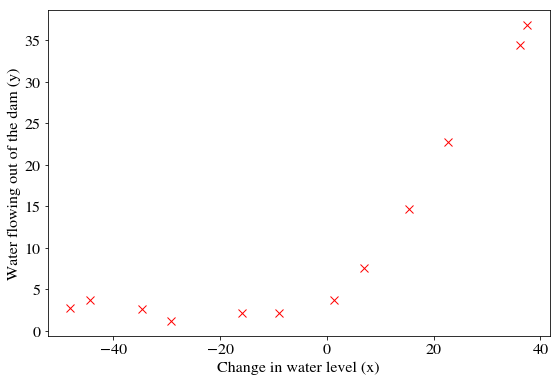

In [37]:
# plot the data in training sample
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(X, y, 'rx', markersize=8)
ax.set_xlabel('Change in water level (x)')
ax.set_ylabel('Water flowing out of the dam (y)')

### 1.2 Regularized linear regression cost function

Recall that regularized linear regression has the following cost function:

$$ J(\theta)=\frac{1}{2m}\sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})^2 + \frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2$$

where $\lambda$ is a regularization parameter which controls the degree of regularization (thus help preventing overfitting). The regularization term puts a penalty on the overal cost J. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well. Note that you should not regularize the $\theta_0$ term.

#### Vectorization

$$J(\theta) = \frac{1}{2m}(X\theta-y)^T(X\theta-y) + \frac{\lambda}{2m}\theta_{1-n}^T\theta_{1-n}$$

$\theta_{1-n}$ in the second term does not contain bias term

### 1.3 Regularized linear regression gradient
Correspondingly, the partial derivative of regularized linear regression's cost for $\theta_j$ is defined as:

$$ \frac{\partial J(\theta)}{\partial \theta_j}=\frac{1}{m} \sum_{i=0}^m(h_\theta(x^{(i)})-y{(i)})x_j^{(i)} \qquad for\;j=0$$

$$ \frac{\partial J(\theta)}{\partial \theta_j}=\left( \frac{1}{m} \sum_{i=0}^m(h_\theta(x^{(i)})-y{(i)})x_j^{(i)}\right)+\frac{\lambda}{m}\theta_j \qquad for\;j\geq 1$$


#### Vectorization
$$ \frac{\partial J(\theta)}{\partial \theta}=\frac{1}{m} X^T(X\theta-y) \qquad for\;j=0$$

$$ \frac{\partial J(\theta)}{\partial \theta}=\frac{1}{m} X^T(X\theta-y)+\frac{\lambda}{m}\theta \qquad for\;j\geq1$$

In [38]:
def linearRegCostFunction(theta, X, y, lmd):
    """computes the 
%   cost of using theta as the parameter for linear regression to fit the 
%   data points in X and y. Returns the cost in J and the gradient in grad
    """
    # number of samples
    m = len(y)
    
    # convert theta to 2d vector
    theta = theta[:, np.newaxis]
    
    # cost function
    J = (X@theta-y).T@(X@theta-y)/2/m + theta[1:, :].T@theta[1:, :]*lmd/2/m
    
    # gradient
    grad = 1 / m * X.T @ (X@theta-y)
    grad[1:, :] += lmd / m * theta[1:, :]
    
    return J[0, 0], grad.flatten()

In [39]:
# test cost function
m, n = X.shape
X_wb = np.concatenate((np.ones((m, 1)), X), axis=1)

lmd = 1
theta0 = np.array([1, 1])

J, grad = linearRegCostFunction(theta0, X_wb, y, lmd)

print(J)
print("Expected ~303.993192")
print(grad)
print("Expected: [ -15.30301567  598.25074417]")

303.99319222
Expected ~303.993192
[ -15.30301567  598.25074417]
Expected: [ -15.30301567  598.25074417]


### 1.4 Fitting linear regression using minimize function




In [40]:
from scipy.optimize import minimize

# initial conidition, 1d array
# n is number of features, in this case, n=1
theta0 = np.zeros(n+1)

lmd = 0

# run optimization
result = minimize(linearRegCostFunction, theta0, args=(X_wb, y, lmd), method='TNC', jac=True, options={'disp': True, 'maxiter':200})
print(result)

     fun: 22.373906495108912
     jac: array([ -3.04942560e-09,  -4.20907605e-09])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 9
     nit: 4
  status: 0
 success: True
       x: array([ 13.08790351,   0.36777923])


Text(0,0.5,'Water flowing out of the dam (y)')

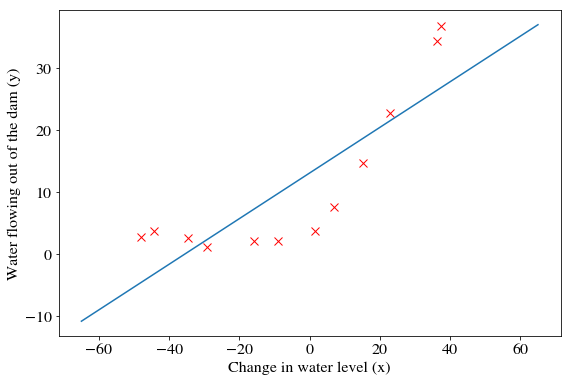

In [41]:
# visualizing result
theta = result.x

# predicted y
Xp = np.linspace(-65, 65, 51)[:, np.newaxis]
mp = Xp.shape[0]
Xp_wb = np.concatenate((np.ones((mp, 1)), Xp), axis=1)
yp = Xp_wb@theta[:, np.newaxis]

# plot
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(X, y, 'rx', markersize=8)
ax.plot(Xp, yp)
ax.set_xlabel('Change in water level (x)')
ax.set_ylabel('Water flowing out of the dam (y)')

## 2 Bias vs. Variance
An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data. 

### 2.1 Learning curves
To plot the learning curve, we need a training and cross validation set error for different training set sizes. 

Recall that the training error for a dataset is defined as: 

$$ J_{train}(\theta)=\frac{1}{2m}\sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})^2$$

Note that regularization term is not included. 

When you are computing the training set error, make sure you compute it on the training subset (i.e., X(1:n,:) and y(1:n)) (instead of the entire training set). However, for the cross validation error, you should compute it over the entire cross validation set.

In [42]:
def learningCurve(X, y, Xval, yval, lmd):
    """returns the train and
%       cross validation set errors for a learning curve. In particular, 
%       it returns two vectors of the same length - error_train and 
%       error_val. Then, error_train(i) contains the training error for
%       i examples (and similarly for error_val(i)).
    """
    
    # X and Xval already has bias items
    
    # number of samples in training set
    m = len(y)
    
    # number of samples in validation set
    n = len(yval)
    
    # init error array
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    
    for i in range(m):
        
        result = minimize(linearRegCostFunction, theta0, args=(X_wb[:(i+1), :], y[:(i+1), :], lmd), method='TNC', jac=True, options={'disp': True})
        theta = result.x[:, np.newaxis]
        
        error_train[i] = ((X[:(i+1), :]@theta-y[:(i+1), :]).T@(X[:(i+1), :]@theta-y[:(i+1), :])/2/(i+1))[0, 0]
        error_val[i] = ((Xval@theta-yval).T@(Xval@theta-yval)/2/n)[0, 0]
        
    return error_train, error_val

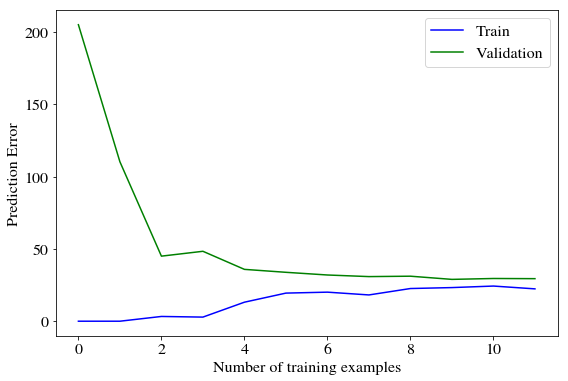

In [43]:
# plot learning curve

lmd = 0

# add bias terms to Xval
mval = len(yval)
Xval_wb = np.concatenate((np.ones((mval, 1)), Xval), axis=1)

# calculate error
error_train, error_val = learningCurve(X_wb, y, Xval_wb, yval, lmd)

# plot learning curve
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(np.arange(m), error_train, 'b', label='Train')
ax.plot(np.arange(m), error_val, 'g', label='Validation')
ax.set_xlabel('Number of training examples')
ax.set_ylabel('Prediction Error')
ax.legend()

Both the train error and cross validation error are high when the number of training examples is increased. This
reflects a high bias problem in the model. The linear regression model is too simple to fit the dataset well. 

## 3 Polynomial regression



In [44]:
def polyFeatures(X, p):
    """takes a data matrix X (size m x 1, 2d array) and
%   maps each example into its polynomial features where
%   X_poly(i, :) = [X(i) X(i).^2 X(i).^3 ...  X(i).^p];
    """
    
    X_poly = np.zeros((X.shape[0], p))
    
    for i in range(p):
        X_poly[:, i] = X[:, 0] ** (i+1)
        
    return X_poly       

### 3.1 Learning Polynomial Regression

Feature normalization function is same as in assignment 1. 

In [45]:
def featureNormalize(X):
    """returns a normalized version of X where
       the mean value of each feature is 0 and the standard deviation
       is 1. This is often a good preprocessing step to do when
       working with learning algorithms.
    """
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1) # note that adding ddof=1 (delta degree of freedom) will calculate unbiased std. 
    X_norm = (X - mu) / sigma # broadcasting in use
    
    return X_norm, mu, sigma

In [46]:
# order of polynomial feature
p = 8

# map feature and normalize for:
# 1) training set
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)
X_poly_wb = np.concatenate((np.ones((m, 1)), X_poly), axis=1)


# 2) Cross Validation set
Xval_poly = polyFeatures(Xval, p)
Xval_poly, mu_val, sigma_val = featureNormalize(Xval_poly)
Xval_poly_wb = np.concatenate((np.ones((mval, 1)), Xval_poly), axis=1)

# 3) test set
mtest = Xtest.shape[0]
Xtest_poly = polyFeatures(Xtest, p)
Xtest_poly, mu_test, sigma_test = featureNormalize(Xtest_poly)
Xtest_poly_wb = np.concatenate((np.ones((mtest, 1)), Xtest_poly), axis=1)

In [47]:
# Learning polynomial regression
lmd = 0
init_theta = np.zeros(p+1)

result = minimize(linearRegCostFunction, init_theta, args=(X_poly_wb, y, lmd), method='TNC', jac=True, options={'disp': True, 'maxiter':200})
theta = result.x

(51, 1)


Text(0,0.5,'Water flowing out of the dam (y)')

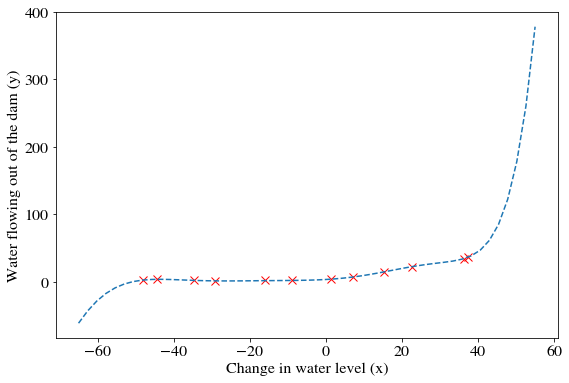

In [49]:
# visualizing result

# predicted y
Xp = np.linspace(-65, 55, 51)[:, np.newaxis]
print(Xp.shape)
mp = Xp.shape[0]
Xp_poly = polyFeatures(Xp, p)
Xp_poly = (Xp_poly - mu) / sigma # need to use mu, sigma of the training sample to normalize this set
Xp_poly_wb = np.concatenate((np.ones((mp, 1)), Xp_poly), axis=1) 

yp = Xp_poly_wb@theta[:, np.newaxis]

# plot
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(X, y, 'rx', markersize=8)
ax.plot(Xp, yp, '--', markersize=10)
# ax.plot(X, X_poly_wb@theta[:, np.newaxis], 'go', markersize=8)
ax.set_xlabel('Change in water level (x)')
ax.set_ylabel('Water flowing out of the dam (y)')